# Simple Ising model example

We start by defining a graph, and simulating a temperature range

In [1]:
import networkx as nx
from Toolbox import infcy # montecarlo methods
from Models import fastIsing # models

import numpy as np

graph = nx.path_graph(5, nx.DiGraph())
graph.add_edge(0, 5)
# graph.add_edge(5, 6)
graph.add_edge(0,0)
# graph = nx.barabasi_albert_graph(10, 4)
model = fastIsing.Ising(graph)


In [2]:
# match magnetization over temp range
temps        = np.linspace(0, 5, 100)
nSamples     = int(1e4)

model.magSide    = '' # equal magnetization sampling
model.updateType = 'single'


mag, sus = model.matchMagnetization(temps, nSamples)
sus[np.isfinite(sus) == 0] = 0 # remove nans
idx     = np.argsort(sus)[-2] # get 'max' idx ; second is used
model.T = temps[idx]


 11%|█         | 11/100 [00:00<00:00, 107.24it/s]

Computing mag per t


100%|██████████| 100/100 [00:00<00:00, 200.60it/s]


In [3]:
deltas        = 10         #conditional time steps
nSamples      = 10000      # max number of states
step          = int(1e3)   
burninSamples = 100        # burninSamples + step = sim. steps until sample
repeats       = int(1e3)   # number of conditional repeats

model.updateType = 'single'
model.reset()
# model.t = 0.1
# snapshots   = infcy.getSnapShots(model, nSamples, step, burninSamples)
# cpx, px, mi = infcy.runMC(model, snapshots, deltas, repeats) # wrapper
res = np.zeros((nSamples, model.nNodes))
rngs= np.random.randint(0, model.nNodes, size = nSamples)
for i in range(nSamples):
    res[i] = model.updateState(rngs[[i]])


In [4]:
nWindow = 10

ps = {}
px = np.zeros((nWindow, model.nNodes, model.nStates))
cpx= {}
Z  = (nSamples - 1 - nWindow) 

statemapper = {i : idx for idx, i in enumerate([-1, 1])}

c = 0
for i in range(nWindow, nSamples - 1):
    tmp   = res[i-nWindow : i]
    state = tuple(tmp[-1])
    c += 1
    ps[state] = ps.get(state, 0) + 1
    if state not in cpx:
        cpx[state] = np.zeros(( nWindow, model.nNodes, model.nStates))
    for t, stateAtTime in enumerate(tmp):
        for node, nodeState in enumerate(stateAtTime):
            px[t, node,   statemapper[nodeState]] += 1 / Z
            cpx[state][t, node, statemapper[nodeState]] += 1 
print(c, Z)  
c = 0

mi = np.zeros((nWindow, model.nNodes))
for state, val in ps.items():
    cpx[state] /= val
    mi += np.nansum(cpx[state] * np.log2(cpx[state]), axis = -1) * val / Z
mi -= np.nansum(px * np.log2(px), axis = -1)


9989 9989


/home/casper/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log2
/home/casper/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in multiply


# Plotting

# The graph


In [5]:
from matplotlib.pyplot import *
from Utils import plotting as plotz # plotting toolbox
positions   = {}
for node, pos in  nx.nx_agraph.graphviz_layout(model.graph, prog = 'neato').items():
    positions[node] =  np.array(pos) * .1

fig, ax = subplots()
p = dict(layout = dict(scale = 1),\
         circle = dict(\
                     radius = 1),\
         annotate = dict(fontsize = 10)
         )
plotz.addGraphPretty(model.graph, ax,  positions, **p)
ax.axis('off')
fig.show()


/home/casper/miniconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


## Magnetization and susceptibilty
Let's draw some plots. First we start with the magnetization as function of temperature. Additionally, we plot the susceptibility. 


/home/casper/miniconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


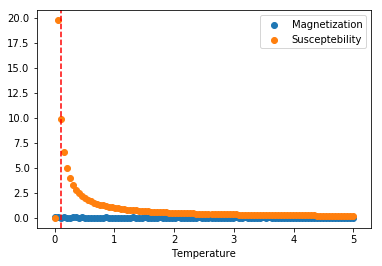

In [6]:
# show mag and sus as function of temperature
fig, ax = subplots()
ax.scatter(temps, mag, label = 'Magnetization')
ax.scatter(temps, sus, label = 'Susceptebility')
ax.axvline(temps[idx], color = 'red', linestyle = 'dashed')
ax.set(xlabel = 'Temperature')
ax.legend()
fig.show()

# Mutual information decay


[6.33067874 3.68887161 2.49966294 3.9615727  3.92267372 3.20335708]


/home/casper/miniconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


{0: 0, 1: 1, 5: 2, 2: 3, 3: 4, 4: 5}

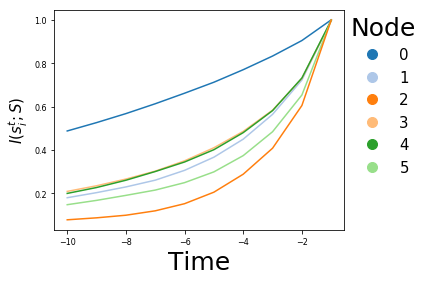

In [7]:
# show mi
colors = cm.tab20(np.arange(model.nNodes)) # colors per node
rcParams['axes.prop_cycle'] = cycler('color', colors)

fig, ax = subplots()
for node, label in sorted(model.rmapping.items(), key = lambda x: x[1]):
    ax.plot(np.arange(-nWindow , 0 ), mi[:, node], color = colors[node])
ax.set_xlabel('Time', fontsize = 25)
ax.set_ylabel('$I(s_i^t ; S)$', fontsize = 15)

elements = [Line2D([0], [0], marker = '.', label = i, \
                  linestyle = 'none', color = colors[i],\
                  markersize = 20) for i in range(model.nNodes)]
ax.legend(handles = elements, title = 'Node', title_fontsize = 25, fontsize = 15, bbox_to_anchor = (1, 1), loc = 'upper left',\
         borderaxespad = 0, frameon = False)
ax.tick_params(labelsize = 8)

fig.savefig('../thesis/presentation/figures/simple_example_time.eps', bbox_inches = "tight")
# fig.subplots_adjust(right = 1.2)
fig.tight_layout()
fig.show()

tmp = np.trapz(mi, np.arange(nWindow), axis = 0)
print(tmp)

model.mapping